Trying to undestand how BERT works, and how to implement a Sentiment CLassification fine tuning BERT.

I have taken help from the following article:
[Sentiment Classification](https://towardsml.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial/)

and also this [Kaggle Notebook](https://www.kaggle.com/houssemayed/imdb-sentiment-classification-with-bert)

In [1]:
!pip install transformers

# Setup and imports

Let's start with installing the transformers library and some required imports for the rest of the notebook

In [2]:
import torch
from transformers import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Data exploration & visualization

In this case, I am using the IMDB reviews dataset given to use in the CODING ASSIGNMENTs which were also used in the resource link, which is also available from kaggle datasets through this link:
https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [3]:
df = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [4]:
#dataset dimensions
df.shape

(50000, 2)

Text(0.5, 0, 'sentiments')

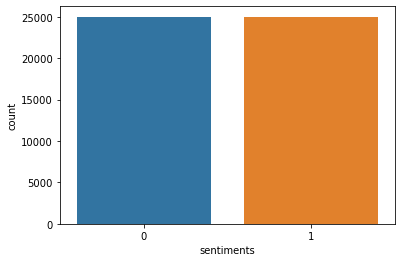

In [5]:
#Labeled reviews barplot
sns.countplot(df.sentiment)
plt.xlabel('sentiments')

As it's shown by the figure above the dataset is perfectly balanced with equal number of reviews text for the two classes.
0 means that the review is negative and 1 for positive

# BERT (Bidirectional Encoder Representations from Transformers)

The Transformers library provides a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers to do the heavy work required for bert model input. As far as I have understood from the resource [Link](https://towardsml.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial/), I am trying to implement SENTIMENT CLASSIFICATION with pre-trained model BERT as the understanding of this will be a huge help for our research project as it is based on the basics of BERT.

In [6]:
#Selecting the bert-base-cased
PRE_TRAINED_MODEL_NAME = '../input/bert-base-cased/'

In [7]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [8]:
#I am checking to understand how Bertencoder is encoding a sentence with a sample string
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1165, 1108, 178, 1314, 1796, 136, 178, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


Some special tokens id: The following tokens are necessary to convert an input data or training/testing data suitable to work with the BERT based models.

In [9]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [10]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [11]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [12]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [13]:
#To do all preprocessing I am specifying some parameters in the encod_plus() method of the tokenizer
encoding = tokenizer.encode_plus(
  sample_txt, #we are using our sample text to encode as necessary for the input to BERT
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [14]:
#The tokens ids list
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1165, 1108,  178, 1314, 1796,  136,  178, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [15]:
#The attentions masked tokens
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [16]:
#let's see how the sentence is tokenized with bert tokenizer
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'i',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In order to get the suitable sequence length we need to take a look at all reviews length and then select the most appropriate one

Text(0.5, 0, 'Token count')

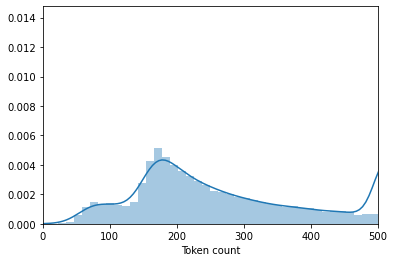

In [17]:
token_lens = []

#looping through the dataset and making a list of length of tokens found in each of the reviews
for txt in df.review:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.xlabel('Token count')

In [18]:
MAX_LEN = 200      #for not consuming much resources
RANDOM_SEED = 42
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

In [19]:
#doing the split of the dataset into training, validation and testing sets
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [20]:
df_train.shape, df_val.shape, df_test.shape

((45000, 2), (2500, 2), (2500, 2))

# Creating Dataset and Dataloader

In [22]:
#Dataset Creation class for creating the specified format dataset for input to BERT
class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long)
    }

In [23]:
#function to create the dataset calling the IMDBDataset class
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(), #separating the reviews
    sentiments=df.sentiment.to_numpy(), #separating the sentiments
    tokenizer=tokenizer, #BERT tokenizer
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [24]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [25]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'sentiments'])

In [26]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['sentiments'].shape)

torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


As you see here we get a training data tensor of size (batch_size * max_length) 

# Reviews Classification with BERT and Hugging Face

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [28]:
#Sentiment CLassifier model
class IMDBClassifier(nn.Module):

  def __init__(self, n_classes):
    super(IMDBClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [29]:
model = IMDBClassifier(len(df['sentiment'].unique()))
model = model.to(device)

In [30]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 200])
torch.Size([16, 200])


In [31]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2306, 0.7694],
        [0.2527, 0.7473],
        [0.4190, 0.5810],
        [0.1832, 0.8168],
        [0.3022, 0.6978],
        [0.2773, 0.7227],
        [0.3677, 0.6323],
        [0.3240, 0.6760],
        [0.3619, 0.6381],
        [0.1985, 0.8015],
        [0.3312, 0.6688],
        [0.3567, 0.6433],
        [0.2987, 0.7013],
        [0.2207, 0.7793],
        [0.4596, 0.5404],
        [0.3260, 0.6740]], grad_fn=<SoftmaxBackward>)

# Training (fine-tuning of BERT for classification task)

How to come up with all hyperparameters? The BERT authors in this [paper](https://arxiv.org/pdf/1810.04805.pdf) have some recommendations for fine-tuning:

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

In [32]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [33]:
#defining the training function
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiments = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
#defining the evaluation model
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [35]:
%%time

train_a = []
train_l = []
val_a = []
val_l = []
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  train_a.append(train_acc)
  train_l.append(train_loss)
  val_a.append(val_acc)
  val_l.append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/opt/conda/conda-bld/pytorch_1587428190859/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
Process Process-5:
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
KeyboardInterrupt
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 337, in _exit_function
    _run_finalizers()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 337, in _exit_function
    _run_finalizers()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", 

KeyboardInterrupt: 

In [ ]:
plt.plot(train_a, label='train accuracy')
plt.plot(val_a, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

# Predictions

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      reviews = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review.extend(reviews)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(sentiments)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# Performance report 

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
class_names = ['negative', 'positive']

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print(review_text)
print()
print(f'True sentiment: {class_names[true_sentiment]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])

# Predict on raw text

In [ ]:
review_text = "The film is too terrible I hate the characters actions and there's a lot of language mistakes"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

If you like it help with a simple up clic